### Data Pre-processing

In [18]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms

transform = transforms.ToTensor()

train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False, download=True, transform=transform)

batch_size = 28
num_workers = 0

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers = 0)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers = 0)

21952 (28, 1, 28, 28)
784 (28, 28)


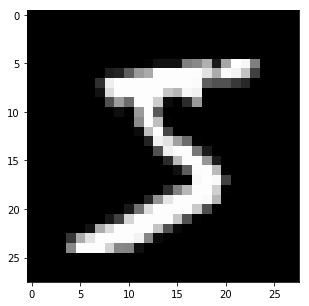

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()
img = np.squeeze(images[0])
print(images.size, images.shape)
print(img.size, img.shape)

fig = plt.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

### Network Architecture: Transpose Convolutional Layers

In [110]:
import torch.nn as nn
import torch.nn.functional as F

class tCNN_Autoencoder(nn.Module):
    def __init__(self):
        super(tCNN_Autoencoder, self).__init__()
        # Encoder
        self.en_conv1 = nn.Conv2d(1,16,3,padding=1)
        self.en_conv2 = nn.Conv2d(16,32,3,padding=1)
        self.en_conv3 = nn.Conv2d(32,4,3,padding=1)
        # Decoder
        self.de_tconv1 = nn.ConvTranspose2d(4,32,3,stride=2)
        self.de_tconv2 = nn.ConvTranspose2d(32,16,2,stride=2)
        self.de_tconv3 = nn.ConvTranspose2d(16,1,2,stride=2)
        
        self.pool = nn.MaxPool2d(2,2)
    
    def forward(self, x):
        #x = x.view(x.size(0),-1)
        #print(x.shape, "before conv1")
        x = F.relu(self.en_conv1(x))
        #print(x.shape, "after conv1")
        x = self.pool(x)
        #print(x.shape, "after pooling at conv1")
        x = F.relu(self.en_conv2(x))
        #print(x.shape, "after conv2")
        x = self.pool(x)
        #print(x.shape, "after pooling at conv2")
        x = F.relu(self.en_conv3(x))
        #print(x.shape, "after conv3")
        x = self.pool(x) #Compressed representation
        #print(x.shape, "after final pooling (compressed representation)")
        x = F.relu(self.de_tconv1(x))
        #print(x.shape, "after tconv1")
        x = F.relu(self.de_tconv2(x))
        #print(x.shape, "after tconv2")
        x = F.sigmoid(self.de_tconv3(x)) # sigmoid to scale the pixel values in grayscale from 0 to 1
        #print(x.shape, "after sigmoid")
        return x

model = tCNN_Autoencoder()
print(model)

tCNN_Autoencoder(
  (en_conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (en_conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (en_conv3): Conv2d(32, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (de_tconv1): ConvTranspose2d(4, 32, kernel_size=(3, 3), stride=(2, 2))
  (de_tconv2): ConvTranspose2d(32, 16, kernel_size=(2, 2), stride=(2, 2))
  (de_tconv3): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [111]:
criterion = nn.MSELoss() # better suited for comparing quantities rather than CrossEntropyLoss for probabilities
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
n_epochs = 20

In [112]:
for epoch in range(n_epochs):
    train_loss = 0
    
    for data in train_loader:
        images, labels = data
        #images = images.view(images.size(0), -1)
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, images)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)
        
    train_loss = train_loss / len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.64}'.format(epoch, train_loss))

Epoch: 0 	Training Loss: 1.8866567137193523961968821822665631771087646484375
Epoch: 1 	Training Loss: 1.4500508819416868533380693406797945499420166015625
Epoch: 2 	Training Loss: 1.3843112176982141914294288653763942420482635498046875
Epoch: 3 	Training Loss: 1.346026449429059912432649070979095995426177978515625
Epoch: 4 	Training Loss: 1.32139925509899835986971083912067115306854248046875
Epoch: 5 	Training Loss: 1.30277252250806885314204919268377125263214111328125
Epoch: 6 	Training Loss: 1.1613938235897245387917564585222862660884857177734375
Epoch: 7 	Training Loss: 0.76720714504077403006476743030361831188201904296875
Epoch: 8 	Training Loss: 0.722754757908727896165146376006305217742919921875
Epoch: 9 	Training Loss: 0.70499977828935656010145294203539378941059112548828125
Epoch: 10 	Training Loss: 0.69105504011292906429986260263831354677677154541015625
Epoch: 11 	Training Loss: 0.67938745750537610224029094752040691673755645751953125
Epoch: 12 	Training Loss: 0.669222762313642305365135

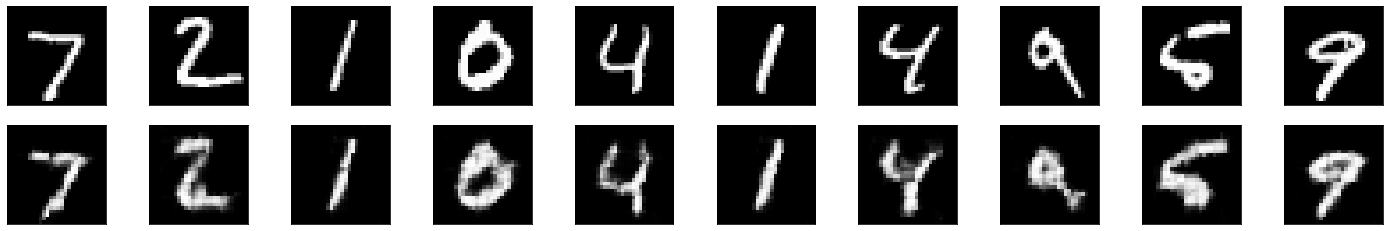

In [114]:
dataiter = iter(test_loader)
images, labels = dataiter.next()
#images_flatten = images.view(images.size(0), -1)
output = model(images)
images = images.numpy()
output = output.view(batch_size, 1, 28, 28)
# Use detach when it's an output that requires_grad
output = output.detach().numpy()
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)